# GNR 638 Mini Project 1

### Name : Sarvesh Patil(22b2276) and Stuti Singla(22b0046)

##### Final code after tring out different pretrainded models

### Phase 1 : Data importing and preprocessing.

In [40]:
# Importing important libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

from tensorflow.keras import models
from keras.models import Model


In [3]:
# Setting few variables
N = 11788
t = 64
epoch = 0

In [4]:
import torch

# Read data from train_test_split to seperate training and testing data.
with open("CUB_200_2011/train_test_split.txt", "r") as file:
    data = file.readlines()

# Convert data to list of floats
data = [list(map(int, line.strip().split())) for line in data]

# Convert list to tensor
tensor_data = torch.tensor(data)



In [5]:
# Storing indices of train and test in two different list.
train_index = []
test_index = []

for i in range(0,N):
    if tensor_data[i][1] == 1:
        train_index.append(i)
    else:
        test_index.append(i) 

In [15]:
# Creating Y train and y test data sets
with open("CUB_200_2011/image_class_labels.txt", "r") as file:
    data = file.readlines()

# Convert data to list of floats
data = [list(map(int, line.strip().split())) for line in data]

# Convert list to tensor
class_labels_num = torch.tensor(data)

y_train = []
y_test = []
for i in range(0, N):
    if i in train_index:
        y_train.append(int(class_labels_num[i][1]))
    else:
        y_test.append(int(class_labels_num[i][1]))

In [16]:
# Creating x train and x test datasets 
with open("CUB_200_2011/images.txt", 'r') as file:
    lines = file.readlines()

data = []
# creating dataset of file locations of images
for line in lines:
    parts = line.split()
    num = int(parts[0])  
    link = ' '.join(parts[1:])  
    link= ".//CUB_200_2011//images//"+link
    data.append([num, link])

data_array = np.array(data)

from PIL import Image
import numpy as np

# Creating two list ie x_train and x_test containing array of image matrix
x_train = []
x_test = []

for i, item in enumerate(data_array, start=1): 
    link = item[1]
    try:
        image = Image.open(link)
       
        resized_image = image.resize((t, t))  # Resize the image to txt pixels
        resized_image_array = np.array(resized_image)   # Convert the resized image to a NumPy array
        if i in train_index:
            x_train.append(resized_image_array)
        else:
            x_test.append(resized_image_array)
    except Exception as e:
        print(f"Error loading image from {link}: {e}")

# Now x_train contains the resized images loaded from the links corresponding to indices present in train_index
# and x_test contains the resized images loaded from the links corresponding to indices not present in train_index

while analyising dimensions of data we found that few images doesnt have RGB values. 

8 such images are found. 

because, the number is less we are not considering them for training or testing purpose.

In [17]:
# TO drop images whoes dimensions are not consistant with requirnments of model
deleted_test_sample_index = [] #this index is with respect test sample 
deleted_train_sample_index = [] #This index is with respect to train sample

# finding index of samples having no RGB dimensions (Number of such images are very less. so deleting them seems to be a good option)
for i in range(len(x_test)):
    if (x_test[i].shape)!=(t,t,3):
        deleted_test_sample_index.append(i)
        print(f'{i}th element of x test is found inhomogenous')
for j in range(len(x_train)):
    if (x_train[j].shape)!=(t,t,3):
        deleted_train_sample_index.append(j)
        print(f'{j}th element of x train is found inhomogenous')

print(deleted_test_sample_index)
print(deleted_train_sample_index)

# Droping thoes datapoints from dataset
for i in range(len(deleted_test_sample_index)):
    x_test.pop(deleted_test_sample_index[i]-i)
    y_test.pop(deleted_test_sample_index[i]-i)
    print(deleted_test_sample_index[i])

for i in range(len(deleted_train_sample_index)):
    x_train.pop(deleted_train_sample_index[i]-i)
    y_train.pop(deleted_train_sample_index[i]-i)
    print(deleted_train_sample_index[i])


195th element of x test is found inhomogenous
3081th element of x test is found inhomogenous
749th element of x train is found inhomogenous
1868th element of x train is found inhomogenous
1869th element of x train is found inhomogenous
1951th element of x train is found inhomogenous
2580th element of x train is found inhomogenous
2762th element of x train is found inhomogenous
[195, 3081]
[749, 1868, 1869, 1951, 2580, 2762]
195
3081
749
1868
1869
1951
2580
2762


In [18]:
x_train = np.array(x_train)
x_test = np.array(x_test)

# Normalize images to the range [0, 1].
x_train = x_train.astype("float32") / 255
x_test  = x_test.astype("float32") / 255

#TO convert y train and test set into categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


Now, our data preprocessing is done and data is ready to load into different models of our choice.


### Phase 1 end

### Phase 2 : Defining model

In [22]:
# Defining complete model
import efficientnet.keras as efn
base_model = efn.EfficientNetB0(input_shape = (t, t, 3), include_top = False, weights = 'imagenet')

# Including fine tuning for last few layers
fine_tune = 5
for layer in base_model.layers:
            layer.trainable = False

if fine_tune > 0:
        for layer in base_model.layers[len(base_model.layers)-fine_tune:len(base_model.layers)]:
            layer.trainable = True

# Adding few layers to help model classify images of our choice
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(201, activation="softmax")(x)
model = Model(base_model.input, x)

from keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [23]:
# To get summary of our model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 32, 32, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 32, 32, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 32, 32, 32)           0         ['stem_bn[0][0]']         

 block2b_bn (BatchNormaliza  (None, 16, 16, 144)          576       ['block2b_dwconv[0][0]']      
 tion)                                                                                            
                                                                                                  
 block2b_activation (Activa  (None, 16, 16, 144)          0         ['block2b_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block2b_se_squeeze (Global  (None, 144)                  0         ['block2b_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block2b_se_reshape (Reshap  (None, 1, 1, 144)            0         ['block2b_se_squeeze[0][0]']  
 e)       

### Phase 2 end

### Phase 3 : Training phase

In [41]:
epoch = 20
eff_history = model.fit(x_train,
                        y_train,
                        batch_size=256, 
                        epochs=epoch, 
                        verbose=1, 
                        validation_split=.25)

model.save('efficientnet_WB')

Epoch 1/20
18/18 [==============================] - 36s 1s/step - loss: 5.6896 - acc: 0.0109 - val_loss: 5.6771 - val_acc: 0.0013
Epoch 2/20
18/18 [==============================] - 17s 953ms/step - loss: 4.8947 - acc: 0.0434 - val_loss: 5.9307 - val_acc: 6.6800e-04
Epoch 3/20
18/18 [==============================] - 17s 959ms/step - loss: 4.3890 - acc: 0.0957 - val_loss: 6.1776 - val_acc: 0.0000e+00
Epoch 4/20
18/18 [==============================] - 20s 1s/step - loss: 3.9569 - acc: 0.1594 - val_loss: 6.4262 - val_acc: 0.0000e+00
Epoch 5/20
18/18 [==============================] - 20s 1s/step - loss: 3.6198 - acc: 0.2218 - val_loss: 6.6618 - val_acc: 0.0000e+00
Epoch 6/20
18/18 [==============================] - 20s 1s/step - loss: 3.3431 - acc: 0.2826 - val_loss: 6.9001 - val_acc: 0.0000e+00
Epoch 7/20
18/18 [==============================] - 18s 1s/step - loss: 3.0101 - acc: 0.3358 - val_loss: 7.1416 - val_acc: 0.0000e+00
Epoch 8/20
18/18 [==============================] - 20s 1s/s

INFO:tensorflow:Assets written to: efficientnet_WB\assets


In [25]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, epoch])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

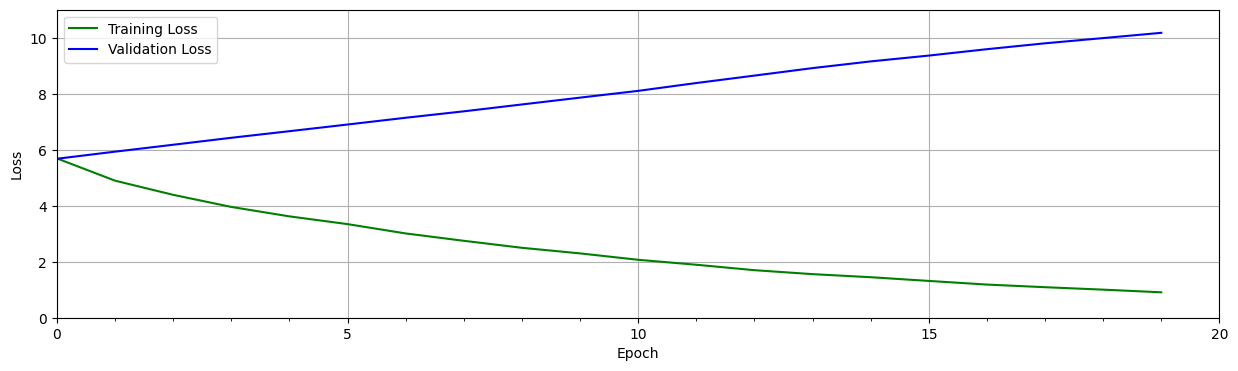

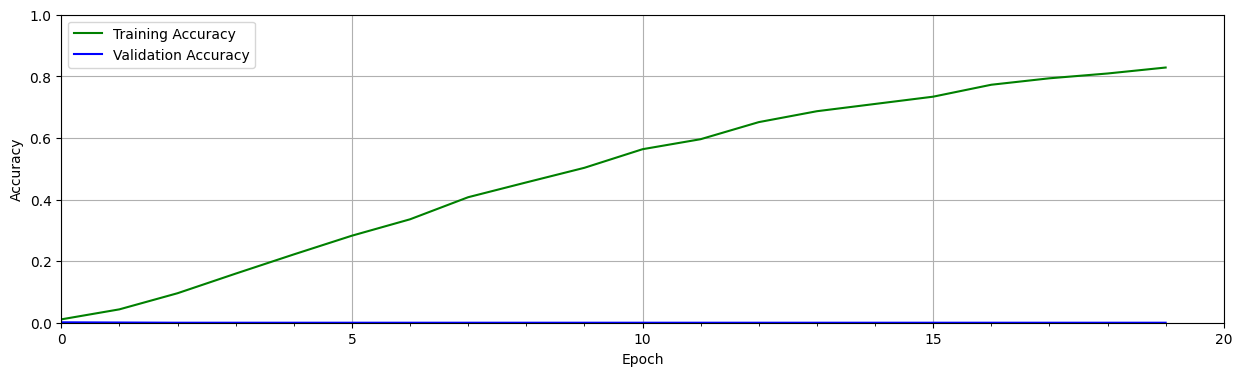

In [42]:
#Retrieve training results.
train_loss = eff_history.history["loss"]
train_acc  = eff_history.history["acc"]
valid_loss = eff_history.history["val_loss"]
valid_acc  = eff_history.history["val_acc"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 11],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"],
            );
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

### Phase 4 : Testing 

In [43]:
reloaded_model = models.load_model('efficientnet_WB')
test_loss, test_acc = reloaded_model.evaluate(x_test, y_test)
print(f"Test accuracy : {test_acc*100:.3f}")

181/181 [==============================] - 29s 146ms/step - loss: 5.5903 - acc: 0.1012
Test accuracy : 10.117


##### We found that the test accuracy is very low. 

##### Trying out methods like data augmentation 

### Phase 5 : Data augmentation

In [51]:
# Creating x train and x test datasets 
#This are augmented datasets

k =3
with open("CUB_200_2011/images.txt", 'r') as file:
    lines = file.readlines()

data = []
# creating dataset of file locations of images
for line in lines:
    parts = line.split()
    num = int(parts[0])  
    link = ' '.join(parts[1:])  
    link= ".//CUB_200_2011//images//"+link
    data.append([num, link])

data_array = np.array(data)

from PIL import Image
import numpy as np



# Creating two list ie x_train and x_test containing array of image matrix
x_train = []
x_test = []

for i, item in enumerate(data_array, start=1): 
    link = item[1]
    try:
        image = Image.open(link)
        resized_image = image.resize((t, t))  # Resize the image to txt pixels
        resized_image_array = np.array(resized_image)   # Convert the resized image to a NumPy array
        if i in train_index:
            x_train.append(resized_image_array)
            for j in range(k):
                image = image.rotate(90)
                resized_image = image.resize((t, t))  # Resize the image to txt pixels
                resized_image_array = np.array(resized_image)   # Convert the resized image to a NumPy array
                x_train.append(resized_image_array)
        else:
            x_test.append(resized_image_array)
    except Exception as e:
        print(f"Error loading image from {link}: {e}")

# Now x_train contains the resized images loaded from the links corresponding to indices present in train_index
# and x_test contains the resized images loaded from the links corresponding to indices not present in train_index

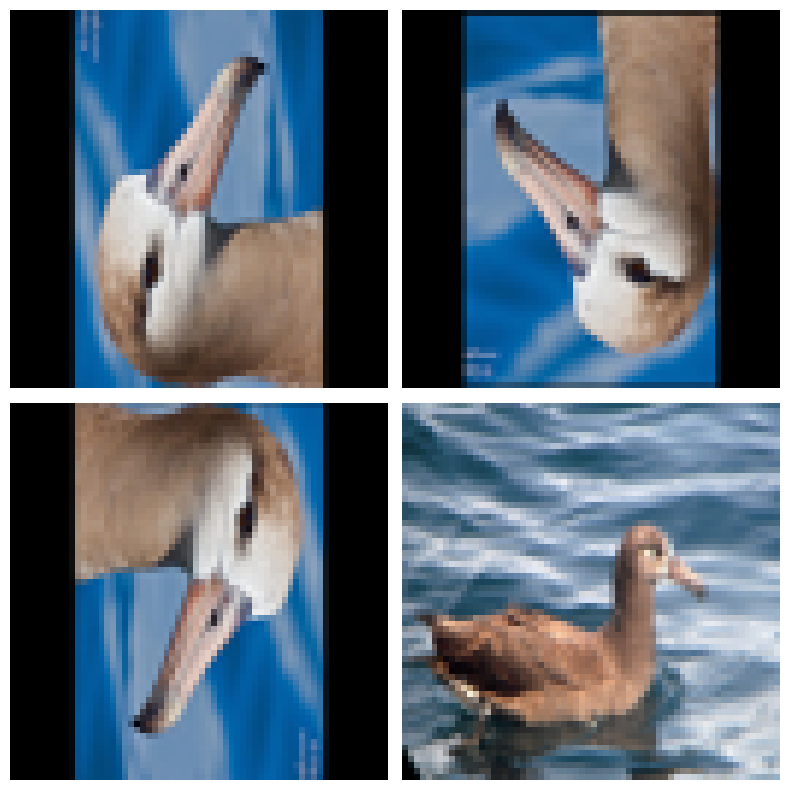

In [52]:
import matplotlib.image as mpimg
images = []
for i in range(1, 5):
    img = x_train[i]
    images.append(img)

# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Loop through images and plot each one
for i, img in enumerate(images):
    axes[i//2, i%2].imshow(img)
    axes[i//2, i%2].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


Images obtained by rotating original image by 90, 180 and 270 degrees 

### Phase 2 : Data Preprocessing for rotated images

In [53]:
with open("CUB_200_2011/image_class_labels.txt", "r") as file:
    data = file.readlines()

# Convert data to list of floats
data = [list(map(int, line.strip().split())) for line in data]

# Convert list to tensor
class_labels_num = torch.tensor(data)

y_train = []
y_test = []
for i in range(0, N):
    if i in train_index:
        for j in range(k+1):
            y_train.append(int(class_labels_num[i][1]))
    else:
        y_test.append(int(class_labels_num[i][1]))

In [54]:
# TO drop images whoes dimensions are not consistant with requirnments of model
deleted_test_sample_index = [] #this index is with respect test sample 
deleted_train_sample_index = [] #This index is with respect to train sample

# finding index of samples having no RGB dimensions (Number of such images are very less. so deleting them seems to be a good option)
for i in range(len(x_test)):
    if (x_test[i].shape)!=(t,t,3):
        deleted_test_sample_index.append(i)
        print(f'{i}th element of x test is found inhomogenous')
for j in range(len(x_train)):
    if (x_train[j].shape)!=(t,t,3):
        deleted_train_sample_index.append(j)
        print(f'{j}th element of x train is found inhomogenous')

print(deleted_test_sample_index)
print(deleted_train_sample_index)

# Droping thoes datapoints from dataset
for i in range(len(deleted_test_sample_index)):
    x_test.pop(deleted_test_sample_index[i]-i)
    y_test.pop(deleted_test_sample_index[i]-i)
    print(deleted_test_sample_index[i])

for i in range(len(deleted_train_sample_index)):
    x_train.pop(deleted_train_sample_index[i]-i)
    y_train.pop(deleted_train_sample_index[i]-i)
    print(deleted_train_sample_index[i])

195th element of x test is found inhomogenous
3081th element of x test is found inhomogenous
2996th element of x train is found inhomogenous
2997th element of x train is found inhomogenous
2998th element of x train is found inhomogenous
2999th element of x train is found inhomogenous
7472th element of x train is found inhomogenous
7473th element of x train is found inhomogenous
7474th element of x train is found inhomogenous
7475th element of x train is found inhomogenous
7476th element of x train is found inhomogenous
7477th element of x train is found inhomogenous
7478th element of x train is found inhomogenous
7479th element of x train is found inhomogenous
7804th element of x train is found inhomogenous
7805th element of x train is found inhomogenous
7806th element of x train is found inhomogenous
7807th element of x train is found inhomogenous
10320th element of x train is found inhomogenous
10321th element of x train is found inhomogenous
10322th element of x train is found inhom

In [55]:
x_train = np.array(x_train)
x_test = np.array(x_test)

# Normalize images to the range [0, 1].
x_train = x_train.astype("float32") / 255
x_test  = x_test.astype("float32") / 255

#TO convert y train and test set into categorical format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [56]:
print(x_train.shape)
print(len(y_train))
print(x_test.shape)
print(len(y_test))


(23952, 64, 64, 3)
23952
(5792, 64, 64, 3)
5792


In [61]:
num_samples_train = len(x_train)
shuffled_indices_train = np.random.permutation(num_samples_train)

# Shuffle both arrays using the same shuffled indices
x_train = x_train[shuffled_indices_train]
y_train = y_train[shuffled_indices_train]

num_samples_test = len(x_test)
shuffled_indices_test = np.random.permutation(num_samples_test)

# Shuffle both arrays using the same shuffled indices
x_test = x_test[shuffled_indices_test]
y_test = y_test[shuffled_indices_test]

In [62]:
model = models.load_model('efficientnet_WB_aug')
epoch = 20
eff_history = model.fit(x_train,
                        y_train,
                        batch_size=256, 
                        epochs=epoch, 
                        verbose=1, 
                        validation_split=.25)

model.save('efficientnet_WB_aug')

Epoch 1/20
71/71 [==============================] - 112s 1s/step - loss: 3.8848 - acc: 0.2529 - val_loss: 3.1285 - val_acc: 0.3372
Epoch 2/20
71/71 [==============================] - 90s 1s/step - loss: 3.3235 - acc: 0.2989 - val_loss: 2.9881 - val_acc: 0.3544
Epoch 3/20
71/71 [==============================] - 90s 1s/step - loss: 2.9934 - acc: 0.3437 - val_loss: 2.8904 - val_acc: 0.3686
Epoch 4/20
71/71 [==============================] - 91s 1s/step - loss: 2.7244 - acc: 0.3883 - val_loss: 2.8050 - val_acc: 0.3784
Epoch 5/20
71/71 [==============================] - 99s 1s/step - loss: 2.4702 - acc: 0.4318 - val_loss: 2.7391 - val_acc: 0.3856
Epoch 6/20
71/71 [==============================] - 84s 1s/step - loss: 2.2592 - acc: 0.4714 - val_loss: 2.6885 - val_acc: 0.3946
Epoch 7/20
71/71 [==============================] - 83s 1s/step - loss: 2.0571 - acc: 0.5110 - val_loss: 2.6361 - val_acc: 0.4025
Epoch 8/20
71/71 [==============================] - 81s 1s/step - loss: 1.8732 - acc: 0.5

INFO:tensorflow:Assets written to: efficientnet_WB_aug\assets


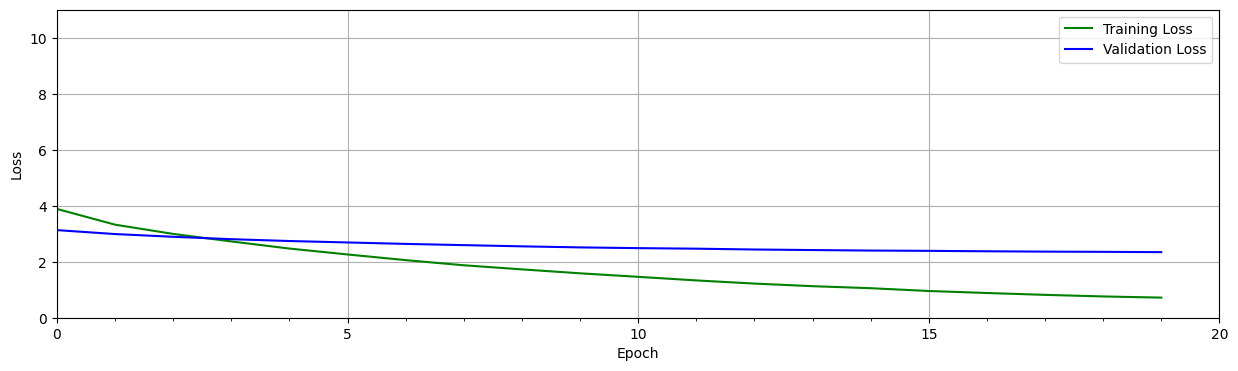

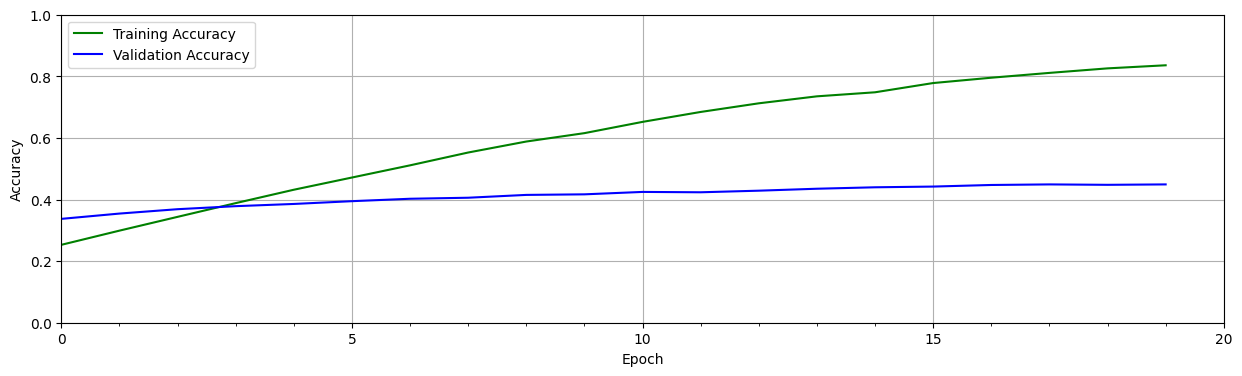

In [63]:
#Retrieve training results.
train_loss = eff_history.history["loss"]
train_acc  = eff_history.history["acc"]
valid_loss = eff_history.history["val_loss"]
valid_acc  = eff_history.history["val_acc"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 11],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"],
            );
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [65]:
reloaded_model = models.load_model('efficientnet_WB_aug')
test_loss, test_acc = reloaded_model.evaluate(x_test, y_test)
print(f"Test accuracy : {test_acc*100:.3f}")

181/181 [==============================] - 39s 197ms/step - loss: 4.8689 - acc: 0.1165
Test accuracy : 11.654


##### we are not able to increase accuracy beyond 12% even by augmentation and random shuffling 